In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import colors
from matplotlib.colors import ListedColormap

from sklearn import metrics

%matplotlib inline

In [24]:
import warnings
import sys

if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [25]:
data = pd.read_csv("../input/customer-personality-analysis/marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [27]:
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [28]:
import datetime

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-12-06
The oldest customer's enrolment date in the records: 2012-01-08


In [29]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [30]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Total categories in the feature Education:
 Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64


In [31]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [32]:
data.describe()

,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,...,0.064079,0.013538,0.009477,0.150271,4.423735e+16,52.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,...,0.244950,0.115588,0.096907,0.357417,2.008532e+16,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,25.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,...,0.000000,0.000000,0.000000,0.000000,2.937600e+16,44.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,...,0.000000,0.000000,0.000000,0.000000,4.432320e+16,51.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,...,0.000000,0.000000,0.000000,0.000000,5.927040e+16,62.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,...,1.000000,1.000000,1.000000,1.000000,9.184320e+16,128.000000,2525.000000,3.000000,5.000000,1.000000


Relative Plot Of Some Selected Features: A Data Subset


<Figure size 432x288 with 0 Axes>

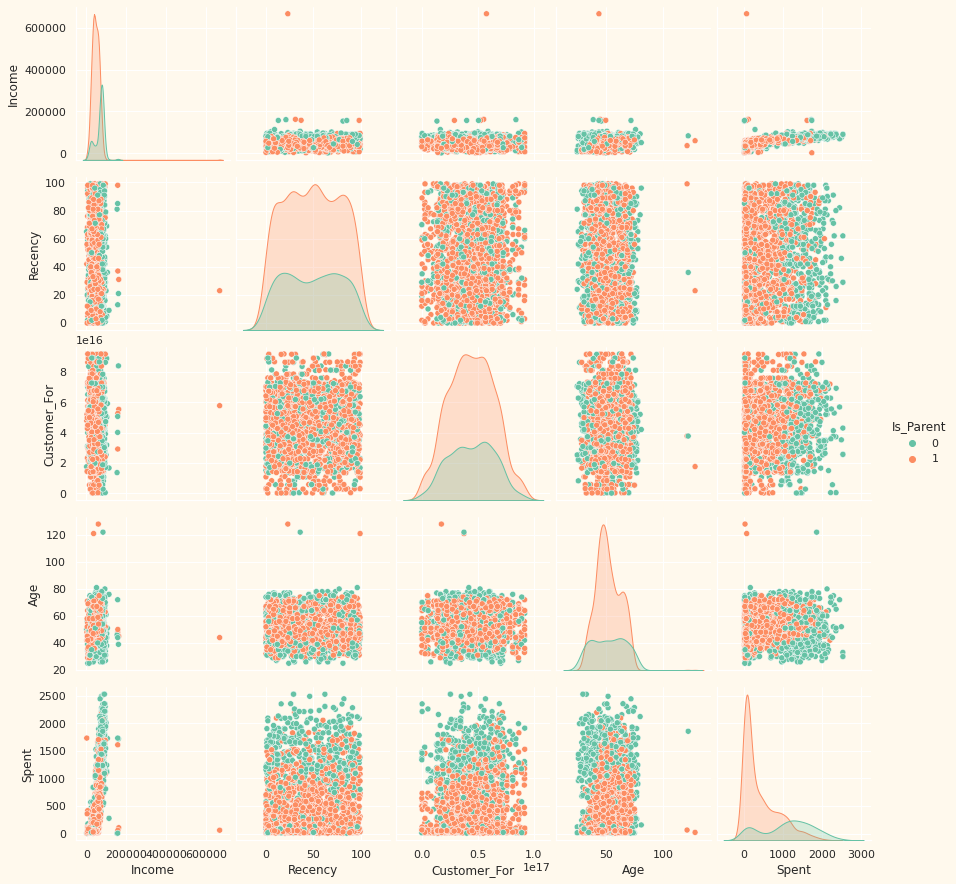

In [34]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(sns.color_palette("Set2").as_hex())

To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Relative Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent", palette = ("Set2"))
 
plt.show()

<AxesSubplot:>

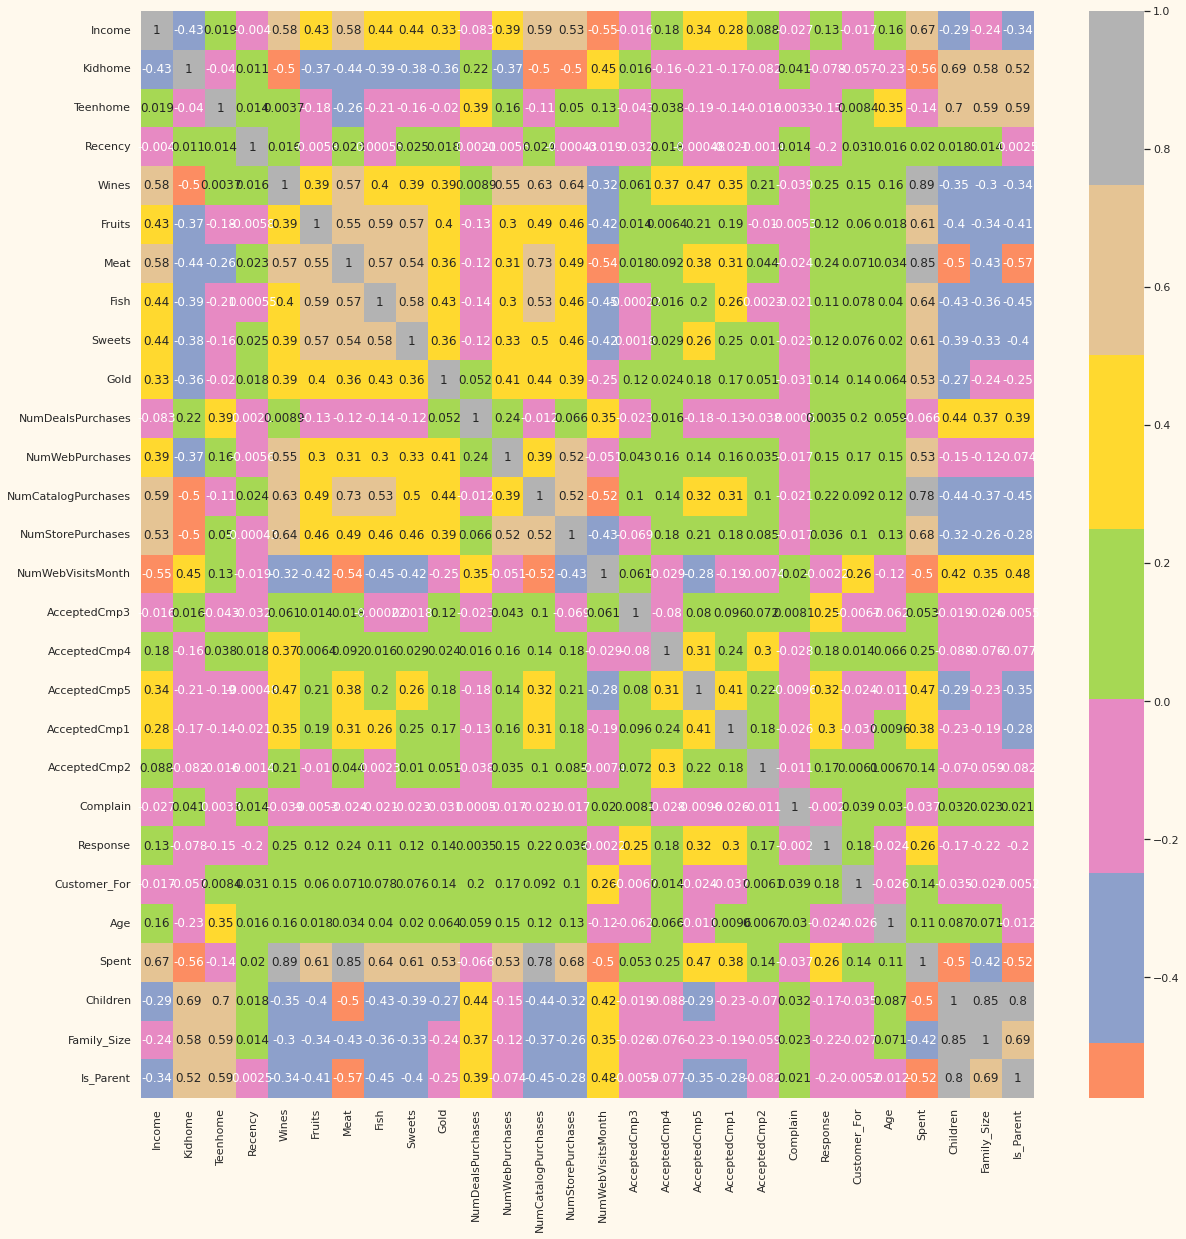

In [35]:
plt.figure(figsize=(20,20))  
sns.heatmap(data.corr(),annot=True, cmap = cmap, center=0)

Text(0.5, 8.95999999999998, 'Income')

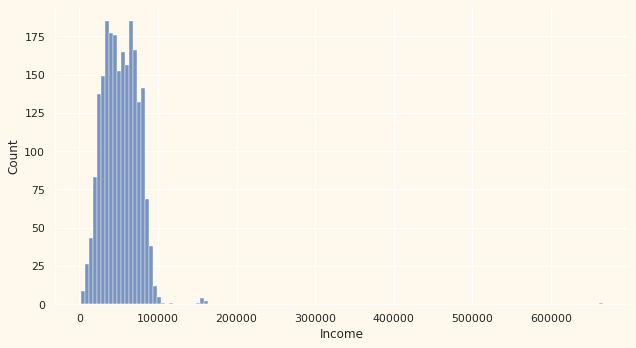

In [36]:
sns.displot(data["Income"], height= 5, aspect=1.8)
plt.xlabel("Income")

Text(0.5, 8.95999999999998, 'Recency')

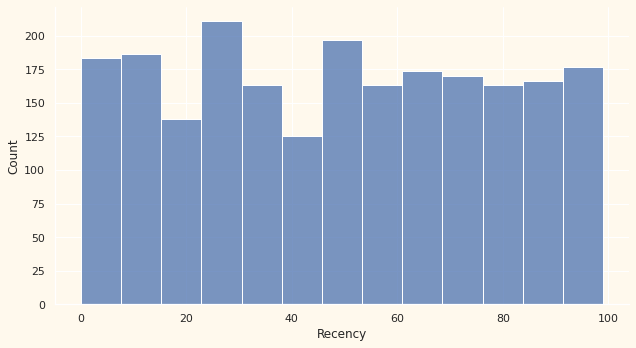

In [37]:
sns.displot(data["Recency"], height = 5, aspect =1.8)
plt.xlabel("Recency")

Text(0.5, 8.95999999999998, 'Customer For')

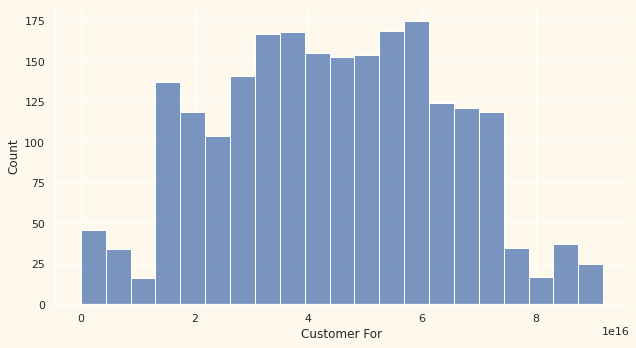

In [38]:
sns.displot(data["Customer_For"], height = 5, aspect = 1.8)
plt.xlabel("Customer For")

Text(0.5, 8.95999999999998, 'Spent')

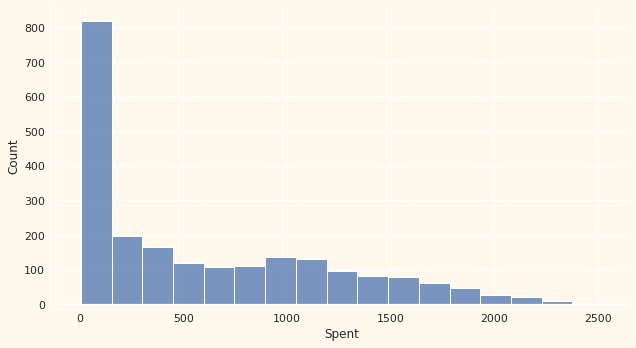

In [39]:
sns.displot(data["Spent"], height = 5, aspect = 1.8)
plt.xlabel("Spent")

Text(0.5, 0, 'Is_Parent')

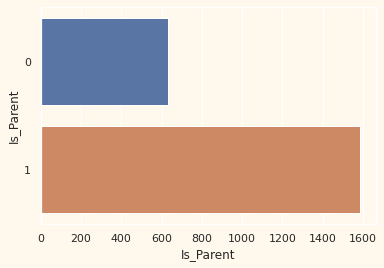

In [40]:
sns.countplot(data = data, y = "Is_Parent")
plt.xlabel("Is_Parent")

In [42]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [43]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()

for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [45]:
from sklearn.preprocessing import StandardScaler

ds = data.copy()

cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [48]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2216.0,-5.130272e-17,2.849804,-5.872597,-2.488285,-0.793442,2.411769,7.382223
col2,2216.0,1.923852e-17,1.699090,-4.273992,-1.332880,-0.160053,1.222542,6.114437
col3,2216.0,-2.164334e-17,1.217972,-4.716967,-0.828109,-0.015525,0.806935,6.584582


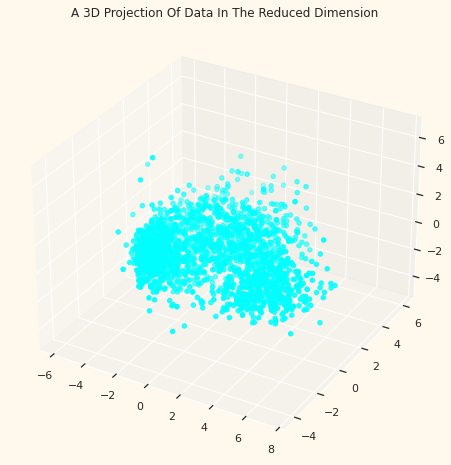

In [49]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c = "cyan", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


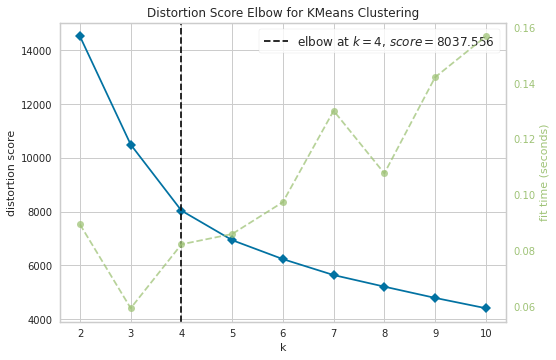

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [59]:
from yellowbrick.cluster import KElbowVisualizer

print('Elbow Method to determine the number of clusters to be formed:')
from sklearn.cluster import KMeans
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [60]:
from sklearn.cluster import AgglomerativeClustering
AC = AgglomerativeClustering(n_clusters=4)

yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC

data["Clusters"]= yhat_AC

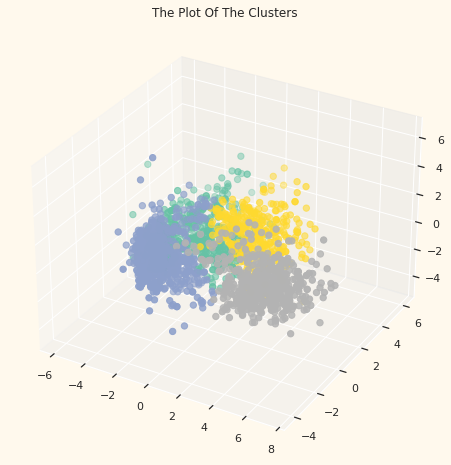

In [51]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c = PCA_ds["Clusters"], marker = 'o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

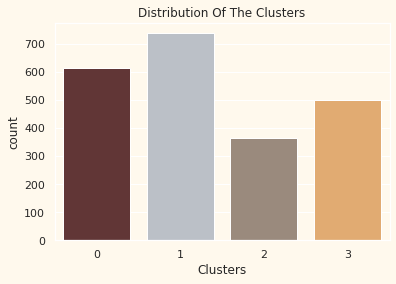

In [52]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x = data["Clusters"], palette = pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

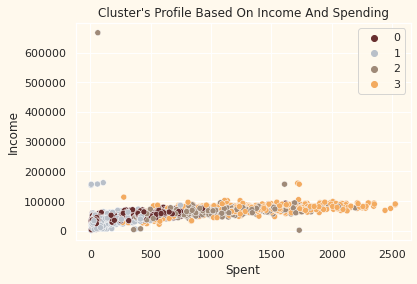

In [53]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

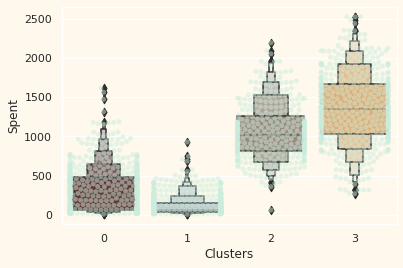

In [55]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

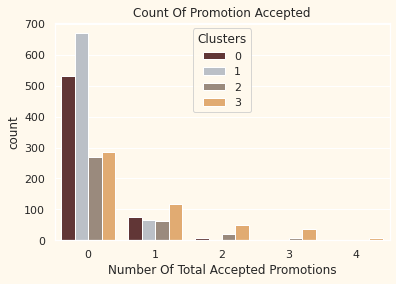

In [56]:

data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]

plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

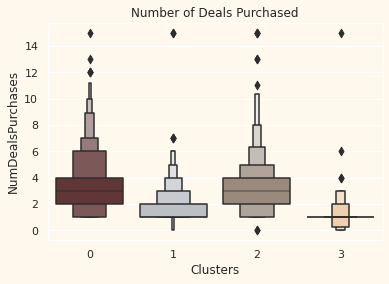

In [57]:
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

<Figure size 432x288 with 0 Axes>

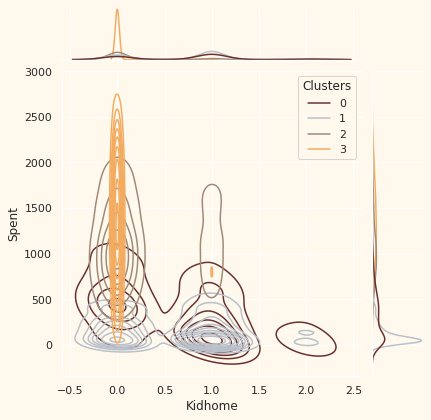

<Figure size 432x288 with 0 Axes>

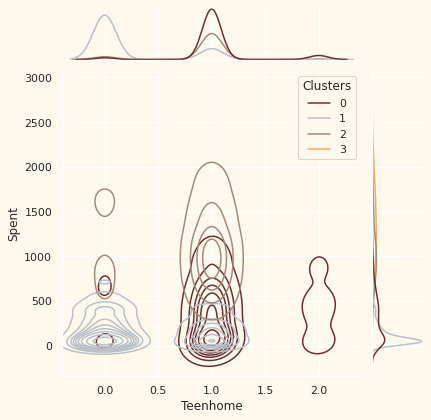

<Figure size 432x288 with 0 Axes>

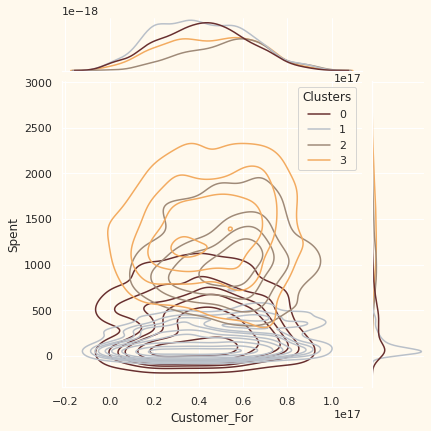

<Figure size 432x288 with 0 Axes>

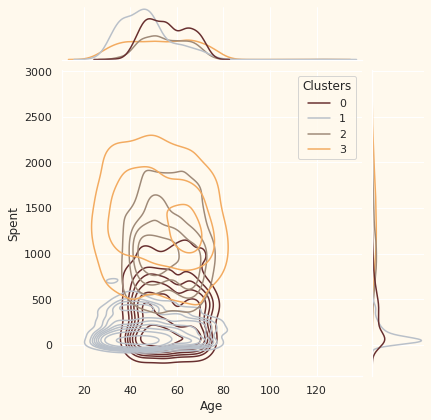

<Figure size 432x288 with 0 Axes>

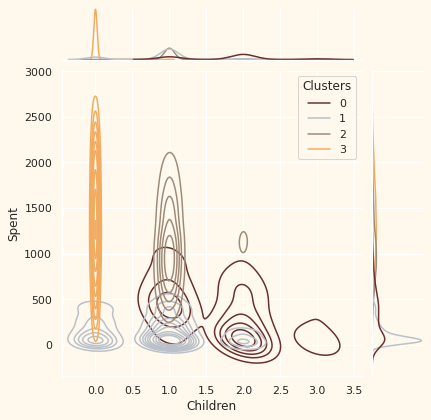

<Figure size 432x288 with 0 Axes>

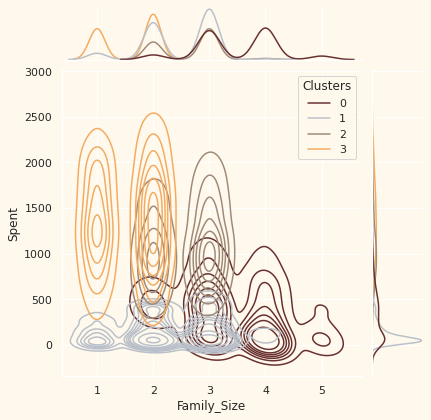

<Figure size 432x288 with 0 Axes>

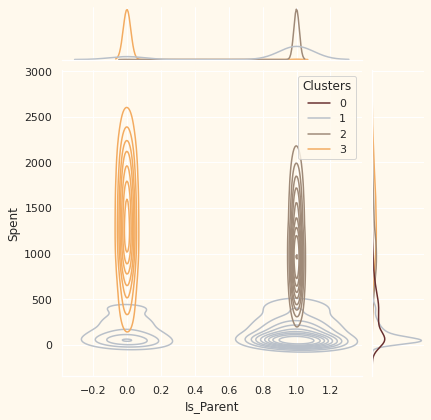

<Figure size 432x288 with 0 Axes>

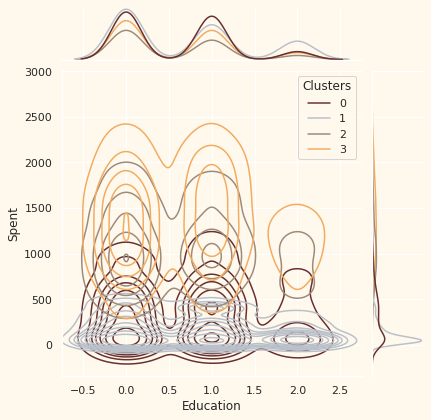

<Figure size 432x288 with 0 Axes>

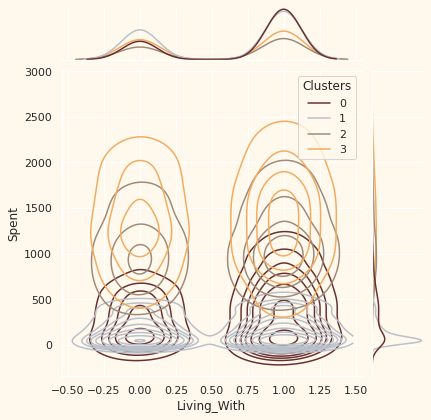

In [58]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette = pal)
    plt.show()

In [61]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

model = Sequential()

model.add(Dense(1, input_shape=(4,), activation='sigmoid'))
model.add(Dense(1, input_shape=(3,), activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________


2023-01-10 18:00:24.443473: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [63]:
X = data[['Income','Recency', 'Customer_For','Spent']]
y = data[["Is_Parent"]]

In [64]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.35,  random_state = 7)

model.fit(train_X, train_y, epochs = 30)

accuracy = model.evaluate(test_X, test_y)[1]

print('Accuracy:',accuracy)

2023-01-10 18:03:35.574175: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
45/45 [==============================] - 1s 1ms/step - loss: 0.6431 - accuracy: 0.7188
Epoch 2/30
45/45 [==============================] - 0s 1ms/step - loss: 0.6309 - accuracy: 0.7188
Epoch 3/30
45/45 [==============================] - 0s 1ms/step - loss: 0.6215 - accuracy: 0.7188
Epoch 4/30
45/45 [==============================] - 0s 997us/step - loss: 0.6142 - accuracy: 0.7188
Epoch 5/30
45/45 [==============================] - 0s 1ms/step - loss: 0.6089 - accuracy: 0.7188
Epoch 6/30
45/45 [==============================] - 0s 1ms/step - loss: 0.6048 - accuracy: 0.7188
Epoch 7/30
45/45 [==============================] - 0s 1ms/step - loss: 0.6018 - accuracy: 0.7188
Epoch 8/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5997 - accuracy: 0.7188
Epoch 9/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5981 - accuracy: 0.7188
Epoch 10/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5970 - accuracy: 0.7188
Epoch 11/30
45/45

In [65]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.35,  random_state = 7)

model.fit(train_X, train_y, epochs=30)

accuracy = model.evaluate(test_X, test_y)[1]

print('Accuracy:',accuracy)

Epoch 1/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 2/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 3/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 4/30
45/45 [==============================] - 0s 993us/step - loss: 0.5943 - accuracy: 0.7188
Epoch 5/30
45/45 [==============================] - 0s 984us/step - loss: 0.5943 - accuracy: 0.7188
Epoch 6/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 7/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 8/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 9/30
45/45 [==============================] - 0s 1ms/step - loss: 0.5943 - accuracy: 0.7188
Epoch 10/30
45/45 [==============================] - 0s 987us/step - loss: 0.5943 - accuracy: 0.7188
Epoch 11/30
4

In [66]:
print(model.evaluate(test_X, test_y)[1])

25/25 [==============================] - 0s 985us/step - loss: 0.6047 - accuracy: 0.7075
0.7074742317199707
